Name:Matthew Seman

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from IPython import display
import pandas as pd
import tensorflow as tf

In [2]:

## helper funciton for loading the horses data
#make sure the horses data is in the same directory as the notebook
#do not change this function
def load_horses_orig(path, image_size):   
    mask_path = path + 'masks/'
    image_path = path + 'images/'
    images = []
    masks = []
    test_images= []
    test_masks =[]
    for i in range(328):
        
        orig_im = cv2.imread(image_path + 'image-{}.png'.format(i))
        orig_im= cv2.cvtColor(orig_im, cv2.COLOR_RGB2BGR)
        
        low_im = cv2.resize(orig_im, dsize=(image_size, image_size))

        orig_mask = cv2.imread(mask_path + 'mask-{}.png'.format(i))
        low_mask = cv2.resize(orig_mask, dsize=(image_size, image_size))
        low_mask = cv2.cvtColor(low_mask, cv2.COLOR_RGB2GRAY)
        bin_mask = (low_mask > 0) + 0
        
    
        images.append(low_im)
        masks.append(bin_mask)


    xtest = np.reshape(np.array(images[250:]), (-1,image_size*image_size*3))
    ytest = np.reshape(np.array(masks[250:]), (-1, image_size * image_size))
    xdata = np.reshape(np.array(images[:200]), (-1,image_size*image_size*3))
    ydata = np.reshape(np.array(masks[:200]), (-1, image_size * image_size))
    yval =  np.reshape(np.array(masks[200:250]), (-1, image_size * image_size))
    xval = np.reshape(np.array(images[200:250]), (-1,image_size*image_size*3))


    return xdata, xval, xtest, ydata, yval, ytest


In [3]:
#change the path address if put the data somewhere else
path = './horses/'
image_size = 32;
xdata, xval, xtest, ydata, yval, ytest = load_horses_orig(path, image_size)

In [4]:
#helper function to drawing horse and its mask
def draw(image, mask):
    fig, (ax1,ax2) = plt.subplots(1,2) 
    ax1.axis('off')
    ax2.axis('off')
    ax1.imshow(np.reshape(image, (image_size,image_size,3)))
    ax2.imshow(np.reshape(mask, (image_size,image_size)), cmap=plt.cm.gray)
    plt.show()

The task is to predict the mask for the horse given the image
Mask is binary image shows the presence of the horse.

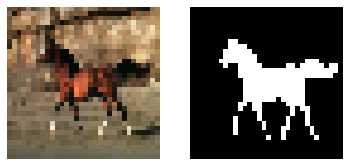

In [5]:
 draw(xdata[0], ydata[0])

In [6]:
train_size = xdata.shape[0]
batch_size = 10
train_dataset = (tf.data.Dataset.from_tensor_slices(np.hstack((xdata, ydata)))
                 .shuffle(train_size).batch(batch_size))

The intersection over union (IOU) is a metric for measuring the performance of image segmentation. The perfect segmentation receives IOU of one.

In [7]:
# Do not change this cell
def iou(ytrue, yprediction):
    yp = yprediction
    yt = ytrue
    yp = yp > 0.5 + 0
    intersect = np.sum(np.minimum(yp, yt),1)
    union = np.sum(np.maximum(yp, yt),1)
    return np.average(intersect / (union+0.0))
        

In [8]:
assert iou(ydata, ydata) == 1.0

We can use feedforwad MLP or CNN  model for image segmentation. Here the input is the image and the output is the segmentation mask.

In [9]:
class NeuralNet(tf.keras.Model):
    
    def construct_CNN(self):
        # COMPLETE ME
        self.model = tf.keras.Sequential(
            [
                tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same', input_shape=(image_size, image_size, 3)),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.MaxPooling2D((2,2)),
                tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.MaxPooling2D((2,2)),
                tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.MaxPooling2D((2,2)),
                tf.keras.layers.Dense(4, activation='relu'),
                tf.keras.layers.Dense(4, activation='relu'),
                tf.keras.layers.UpSampling2D((2,2)),
                tf.keras.layers.Conv2DTranspose(32, kernel_size=3, activation='relu', padding='same'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Conv2DTranspose(32, kernel_size=3, activation='relu', padding='same'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Conv2DTranspose(32, kernel_size=3, activation='relu', padding='same'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.UpSampling2D((2,2)),
                tf.keras.layers.Conv2DTranspose(32, kernel_size=3, activation='relu', padding='same'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Conv2DTranspose(32, kernel_size=3, activation='relu', padding='same'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.UpSampling2D((2,2)),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(128, activation='relu'),
                tf.keras.layers.Dropout(.2),
                tf.keras.layers.Dense(image_size*image_size)
                
            ]
         )
        pass

    
    def construct_MLP(self):
         self.model = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(image_size, image_size, 3), dtype='float32'),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(500, activation='relu'),
                tf.keras.layers.Dropout(.2, input_shape=(500,)),
                tf.keras.layers.Dense(20, activation='relu'),
                tf.keras.layers.Dense(image_size*image_size)
            ]
         )
    
    
    def __init__(self, network_type = 'MLP'):
        super(NeuralNet, self).__init__()
        #DOCUMENT ME
        #SGD is a stochastic gradient descent optimizer that also allows for use of momentum
        #momentum is a smoothing hyperparameter to increase descents and dampen oscillation(Set to zero in regular gradient descent)
        
        #self.optimizer = tf.keras.optimizers.SGD(0.1)
        
        #What are the other available optimizers
        
        #Reduced Learning rate on Adam optimizer gives best performance with current CNN model
        self.optimizer = tf.keras.optimizers.Adam(0.001)
        
        #Test your code with different optimizers
        

        
        
        if network_type == 'MLP':
            self.construct_MLP();
        else:
            self.construct_CNN();
        

    #DOCUMENT ME
    #Defines the forward prediction for the model in which the sigmoid of x is taken using low level tensorflow function
    def forward(self, x, predict=True):
        if predict:
            return tf.nn.sigmoid(self.model(x))
        return self.model(x)
  
    def get_loss(self, x, yt):
        x = tf.reshape(x, (-1, image_size, image_size, 3))
        yt = tf.reshape(yt, (-1, image_size * image_size))
        ylogits = self.forward(x, predict=False);
        
        #DOCUMENT ME
        #What is the difference of sigmoid_cross_entropy_with_logits and sigmoid_cross_entropy?
        #sigmoid cross entropy with logits uses logits(log-odds function) and labels of y data to compute logistic loss
        cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=ylogits, labels=yt);
        
        
        return tf.reduce_sum(cross_ent)
  
   
    def train_step(self, xbatch,ybatch):
        
        #DOCUMENT ME
        #GradientTape() watches variables within its context, in this case loss, and records gradients calculated
        #Used for automatic differentiation
        with tf.GradientTape() as tape:
            loss = self.get_loss(xbatch, ybatch)
        #DOCUMENT ME
        #Calculate the gradient of the target variable from the GradientTape, in this case loss. Store in gradients
        gradients = tape.gradient(loss, model.trainable_variables)
        
        #DOCUMENT ME
        #apply_gradients applies gradient descent and updates the weights of the model
        self.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        return tf.reduce_sum(loss)

    def predict(self, x):
        y = self.forward(x, predict=True)
        return y.numpy() #tf.reshape(y, (-1, image_size, image_size)).numpy()


In [10]:
model = NeuralNet('CNN')
#model = NeuralNet('MLP')
train_iou = []
val_iou = []
test_iou = []
epoch = 1;
best_val_iou = -1;
best_test_iou = -1

In [11]:
#Check Model
modelCheck = tf.keras.Sequential(
            [
                tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same', input_shape=(image_size, image_size, 3)),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.MaxPooling2D((2,2)),
                tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.MaxPooling2D((2,2)),
                tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.MaxPooling2D((2,2)),
                tf.keras.layers.Dense(32, activation='relu'),
                tf.keras.layers.Dense(32, activation='relu'),
                tf.keras.layers.UpSampling2D((2,2)),
                tf.keras.layers.Conv2DTranspose(32, kernel_size=3, activation='relu', padding='same'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.UpSampling2D((2,2)),
                tf.keras.layers.Conv2DTranspose(32, kernel_size=3, activation='relu', padding='same'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.UpSampling2D((2,2)),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(128, activation='relu'),
                tf.keras.layers.Dropout(.2),
                tf.keras.layers.Dense(image_size*image_size)
            ]
         )
modelCheck.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_11 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 batch_normalization_12 (Bat  (None, 16, 16, 32)       128       
 chNormalization)                                                
                                                      

In [12]:
#Adopt similar training loop for other problems

#Originally 5000
max_epoch = 100

while epoch < max_epoch:
    loss = 0.0
    for batch in train_dataset:
        xbatch = batch[:,:image_size*image_size*3]
        ybatch = batch[:,image_size*image_size*3:]
        xbatch = tf.cast(xbatch, tf.float32);
        ybatch = tf.cast(ybatch, tf.float32);
        loss += model.train_step(xbatch, ybatch);
  
    ydata_pred = model.predict(tf.reshape(xdata, (-1, image_size, image_size, 3 )));
    yval_pred = model.predict(tf.reshape(xval, (-1, image_size, image_size, 3 )));
    ytest_pred = model.predict(tf.reshape(xtest, (-1, image_size, image_size, 3 )));
    
    train_iou.append(iou(ydata,ydata_pred))
    val_iou.append(iou(yval,yval_pred))
    test_iou.append(iou(ytest,ytest_pred))

    if val_iou[-1] > best_val_iou:
        best_test_iou = test_iou[-1]
        best_val_iou = val_iou[-1]
        model.save_weights("best_model");
    
  
    print("Epoch {}, Loss: {:0.3}, IOU - Train: {:0.3} Valid: {:0.3} Test: {:0.3}".format( epoch, loss.numpy(), train_iou[-1], val_iou[-1], best_test_iou))
  

 
    epoch += 1


Epoch 1, Loss: 1.08e+05, IOU - Train: 0.507 Valid: 0.483 Test: 0.502
Epoch 2, Loss: 7.22e+04, IOU - Train: 0.517 Valid: 0.489 Test: 0.506
Epoch 3, Loss: 7.04e+04, IOU - Train: 0.512 Valid: 0.481 Test: 0.506
Epoch 4, Loss: 7e+04, IOU - Train: 0.516 Valid: 0.488 Test: 0.506
Epoch 5, Loss: 7e+04, IOU - Train: 0.507 Valid: 0.472 Test: 0.506
Epoch 6, Loss: 6.96e+04, IOU - Train: 0.515 Valid: 0.486 Test: 0.506
Epoch 7, Loss: 6.91e+04, IOU - Train: 0.509 Valid: 0.474 Test: 0.506
Epoch 8, Loss: 6.92e+04, IOU - Train: 0.521 Valid: 0.49 Test: 0.508
Epoch 9, Loss: 6.84e+04, IOU - Train: 0.523 Valid: 0.487 Test: 0.508
Epoch 10, Loss: 6.76e+04, IOU - Train: 0.535 Valid: 0.492 Test: 0.512
Epoch 11, Loss: 6.72e+04, IOU - Train: 0.551 Valid: 0.507 Test: 0.539
Epoch 12, Loss: 6.55e+04, IOU - Train: 0.545 Valid: 0.487 Test: 0.539
Epoch 13, Loss: 6.47e+04, IOU - Train: 0.558 Valid: 0.499 Test: 0.539
Epoch 14, Loss: 6.36e+04, IOU - Train: 0.562 Valid: 0.517 Test: 0.539
Epoch 15, Loss: 6.39e+04, IOU - Trai

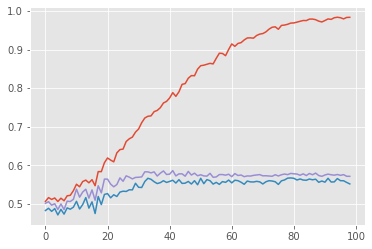

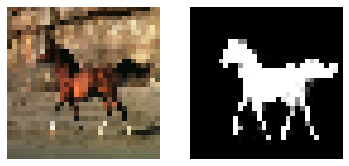

In [13]:
fig, ax = plt.subplots(1,1)
pd.Series(train_iou).plot(ax=ax)
pd.Series(val_iou).plot(ax=ax)
pd.Series(test_iou).plot(ax=ax)
fig.canvas.draw()

draw(xdata[0], ydata_pred[0])

In [14]:
model.load_weights("best_model")
ypred = model.predict(tf.reshape(xtest, (-1, image_size, image_size, 3 )));

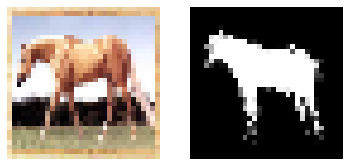

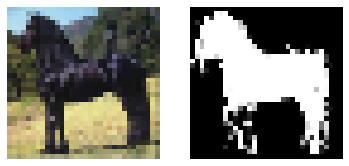

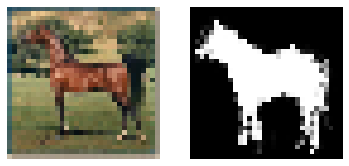

In [15]:
draw(xtest[10], ypred[10])
draw(xtest[25], ypred[25])
draw(xtest[20], ypred[20])

In [16]:
iou(ytest, ypred)

0.5794338402510538